# Exploratory Analysis

## Table of contents
1. [Dataset](#introduction)
2. [Exploratory Data Analysis](#paragraph1)
3. [Refining the data](#paragraph2)
4. [Simple Regression](#paragraph2)
5. [DNN Regression](#paragraph2)
6. [XGBoost](#paragraph2)
7. [Model Comparison](#)

## 1. Dataset

The dataset used is from [Kaggle](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data). The dataset was last updated 3 years ago, and is under public domain. I will demonstrate simple data analytics techniques such as different types of regressions to create a model with the highest explanatory power. 

In [359]:
import zipfile
import os 
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
from matplotlib import transforms
from scipy.stats import gaussian_kde
from scipy import stats
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline  

In [360]:
# if not os.path.isdir("data"):
#     with zipfile.ZipFile(file='airbnb_data.zip', mode='r') as zip_ref:
#         zip_ref.extractall(path='data')

In [361]:
df = pd.read_csv("data/AB_NYC_2019.csv",index_col=0)

In [362]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


## 2. Exploratory Data Analysis

In [363]:
eda_df = df.copy()

for c in ["price","minimum_nights","number_of_reviews"]:
    eda_df = eda_df[(np.abs(stats.zscore(df[c])) < 2)]

C:\Users\nemet\AppData\Local\Temp\ipykernel_22120\64900089.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eda_df = eda_df[(np.abs(stats.zscore(df[c])) < 2)]


### 2.1. Distribution of features by neigborhoud groups

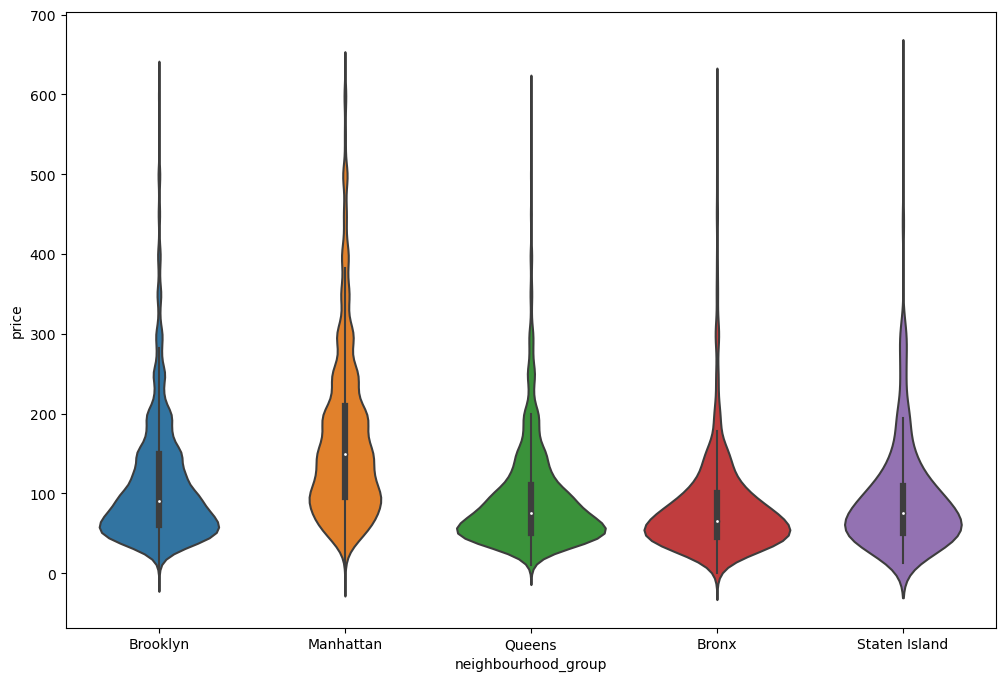

In [364]:
plt.figure(figsize=(12,8))
ax = sns.violinplot(x="neighbourhood_group", y="price", data=eda_df)
plt.show()

### 2.2. Plotting latitude and longitude on NYC map

<Figure size 640x480 with 0 Axes>

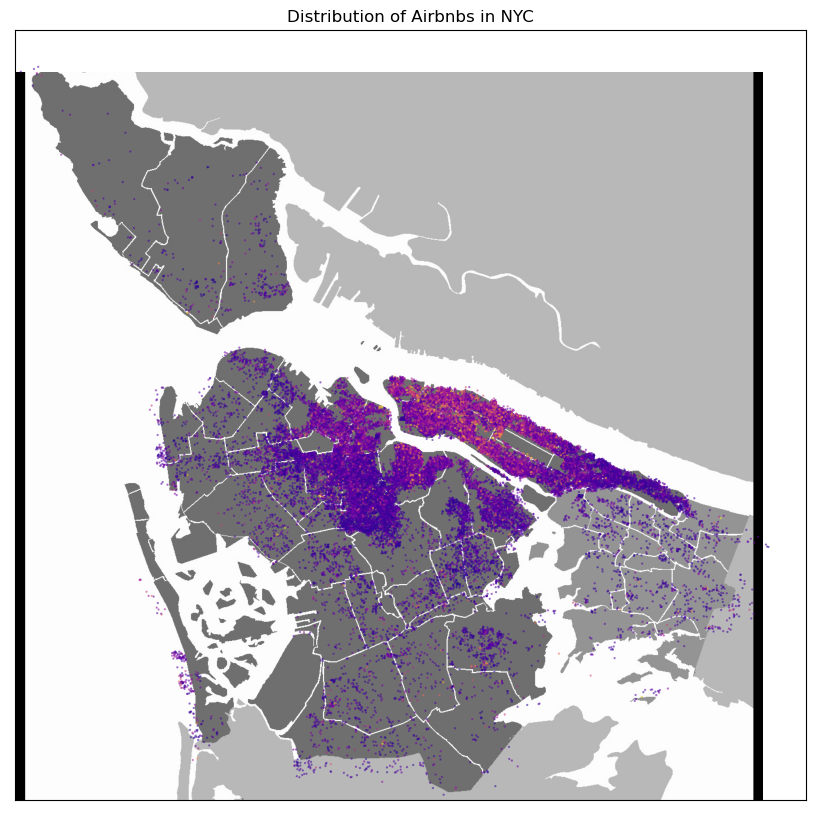

In [365]:
img = Image.open("data/New_York_City_.jpeg").rotate(270)
plt.figure()
fig, ax = plt.subplots(figsize=(20,10))
width,height = img.size
transp_lat =(eda_df["latitude"]-eda_df["latitude"].min())/(eda_df["latitude"].max()-eda_df["latitude"].min())*width
transp_long =(eda_df["longitude"]-eda_df["longitude"].min())/(eda_df["longitude"].max()-eda_df["longitude"].min())*height
ax.imshow(img);
colors = (eda_df["price"]-eda_df["price"].min())/(eda_df["price"].max()-eda_df["price"].min())
ax.scatter(transp_lat+10,transp_long-10, c=eda_df["price"],alpha=0.5,cmap="plasma",s=0.4);
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
ax.set_title("Distribution of Airbnbs in NYC");


### 2.3. Missing Values

last_review          10052
reviews_per_month    10052
host_name               21
name                    16
dtype: int64


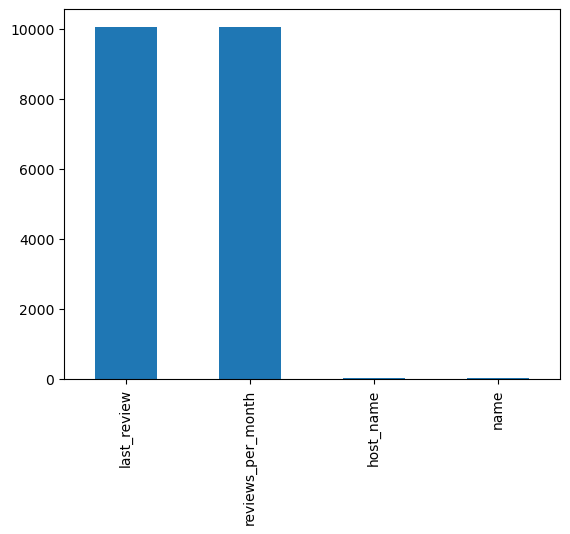

In [366]:
missing = pd.isna(df).sum().sort_values(ascending=False)
print(missing[missing>0])
missing[missing >0].plot.bar();

### 2.4 Inter-correlation of features

Plotting a correlation matrix of the quantitative features can help establish grounds for feature engineering or exclusion of variables. In this case Pearson's correlation coefficients are weak or non-existent, therefore we can leave them as-is.

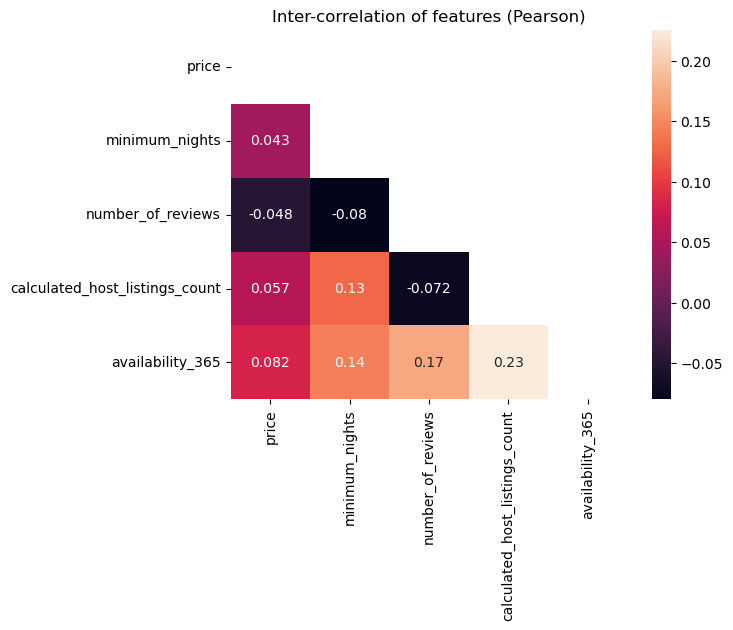

In [367]:
corr_mat = df[["price","minimum_nights","number_of_reviews","calculated_host_listings_count","availability_365"]].corr()

ax = plt.axes()
matrix = np.triu(corr_mat)
sns.heatmap(corr_mat,annot=True, ax = ax,mask=matrix)
ax.set_title('Inter-correlation of features (Pearson)')
plt.show()

In [368]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

### 3. Refining the data

### 3.1. Basic preparations

**3.1. Removing Nan values from rows**

In [369]:

df = df.dropna()
df = df.drop(["name","host_id","host_name","latitude","longitude","last_review"],axis=1)

**3.2. Encoding categorical variables**

In [370]:
df = pd.get_dummies(df,columns=["room_type","neighbourhood_group","neighbourhood"],prefix="_")

**3.3 Splitting data to train and test set with label: price**

In [371]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [372]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('price')
test_labels = test_features.pop('price')

**3.4. Adding keras.Normalization layer**

In [373]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

## 4. Simple Linear Regression

In [374]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [375]:
lr_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
lr_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 231)              463       
 ion)                                                            
                                                                 
 dense_33 (Dense)            (None, 1)                 232       
                                                                 
Total params: 695
Trainable params: 232
Non-trainable params: 463
_________________________________________________________________


In [376]:
lr_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

lr_history = lr_model.fit(
    train_features,
    train_labels,
    epochs=10,
    verbose=0,
    validation_split = 0.2)


In [377]:
y_hat = lr_model.predict(test_features)


243/243 [==============================] - 0s 744us/step


In [378]:
print(y_hat.flatten())
print(test_labels.to_numpy())
print(mean_absolute_error(test_labels.to_numpy(),y_hat.flatten()))

[100.90349   91.789566 148.13786  ... 100.70367  158.30896   15.795761]
[ 85  89 120 ... 135 150 235]
176.69287168531304


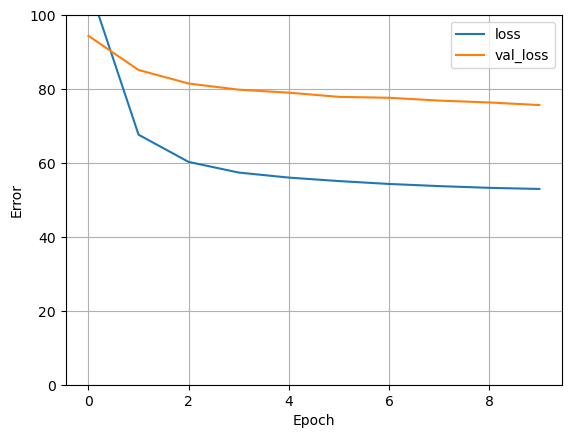

In [379]:

plot_loss(lr_history)

## 5. DNN Regression

In [380]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [381]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 231)              463       
 ion)                                                            
                                                                 
 dense_34 (Dense)            (None, 32)                7424      
                                                                 
 dense_35 (Dense)            (None, 32)                1056      
                                                                 
 dense_36 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8,976
Trainable params: 8,513
Non-trainable params: 463
_________________________________________________________________


In [382]:
dnn_history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=10)

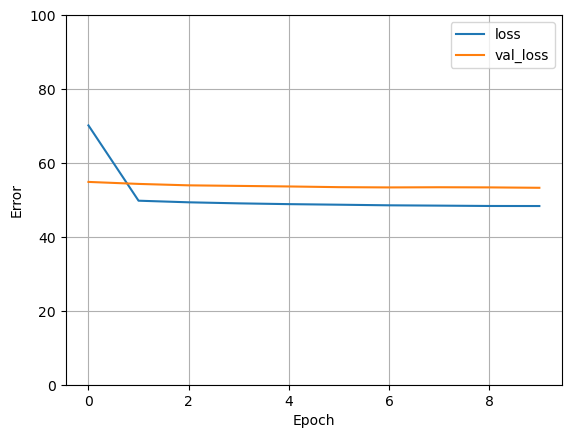

In [383]:
plot_loss(dnn_history)

## 6. XGBoost

Another, more advanced technique is XGBoost, which performed better than regression in previous Kaggle competitions so let's give it a shot. We will use Scikit-Learn's grid search method to tune hyperparams. 

In [384]:
from xgboost import XGBClassifier,XGBRegressor

In [385]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
# parameters = {'booster':'gbtree', 'min_child_weight':5,
#               "max_depth":3,
#               "gamma":0}
xgb_model = XGBRegressor(booster="gbtree",min_child_weight=5,max_depth=3)
# clf =GridSearchCV(xgb_model,parameters)
xgb_history = xgb_model.fit(train_features, train_labels)

## 7. Model Comparison

In [387]:

y_pred_xgb = xgb_model.predict(test_features)
y_pred_slr = lr_model.predict(test_features)
y_pred_dnn = dnn_model.predict(test_features)


243/243 [==============================] - 0s 1ms/step


In [388]:
print(test_labels.to_numpy().shape)
print(y_pred_xgb.flatten().shape)

(7764,)
(7764,)


In [389]:
mae_dnn = mean_absolute_error(test_labels.to_numpy(),y_pred_dnn.flatten())
mae_xgb =mean_absolute_error(test_labels.to_numpy(),y_pred_xgb.flatten())
mae_slr = mean_absolute_error(test_labels.to_numpy(),y_pred_slr.flatten())

r2_dnn = r2_score(test_labels.to_numpy(),y_pred_dnn.flatten())
r2_xgb =r2_score(test_labels.to_numpy(),y_pred_xgb.flatten())
r2_slr = r2_score(test_labels.to_numpy(),y_pred_slr.flatten())

Text(0.5, 1.0, 'MAE scores for models')

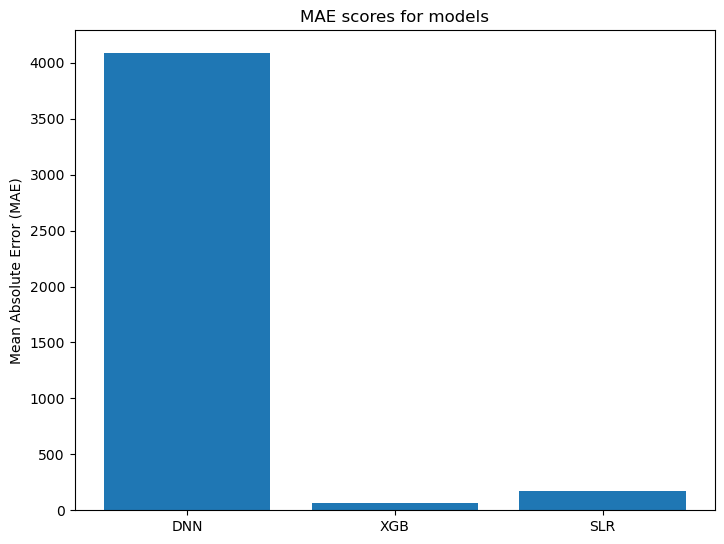

In [393]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(["DNN","XGB","SLR"],[mae_dnn,mae_xgb,mae_slr])
ax.set_ylabel("Mean Absolute Error (MAE)")
ax.set_title("MAE scores for models")

In [400]:
print("r2 score for XGB: {:.2f}".format(r2_xgb))
print("r2 score for DNN: {:.2f}".format(r2_dnn))
print("r2 score for SLR: {:.2f}".format(r2_slr))

r2 score for XGB: 0.08
r2 score for DNN: -2302870.78
r2 score for SLR: -1706.78
